# Experiments on Real Data
For the details of the experimental setup and results please see Section 5.2 of the main text.

In [1]:
# IMPORTS

# BASICS
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random
from math import exp, sqrt, log, tanh
from copy import deepcopy
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# STYLE (optional)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-dark-palette')
plt.rcParams["mathtext.fontset"] = "cm"


# SCIKIT-LEARN
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import datasets
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [2]:
# CONFIDENCE BASED REFUSAL MECHANISM


def calibrate(C,Xcal, ycal, eps):
    # Computes and returns the minimum threshold for the classifier C 
    # that gives the empirical error rate eps on the calibration data (Xcal, ycal).
    # Note: Assumes C supports predict.proba() method.
    
    A = C.predict_proba(Xcal)
    pred_cal = C.predict(Xcal)
    n_cal, n_features = Xcal.shape
    
    # Compute potential threshold points
    pt = A.max(axis=1)
    
    # Find the smallest temprorary threshold to satisfy the condition
    a = np.argsort(pt)
    
    errors = sum(pred_cal != ycal) 
    
    predictions = n_cal 
    threshold = 1
    
    if errors/predictions > eps:
        for i in a: # As we change the threshold, we refuse one more data point each time.
            if pred_cal[i] != ycal[i]:
                errors = errors - 1 # We got rid of one error
            predictions = predictions - 1
            if errors/predictions <= eps:
                threshold = pt[i]
                break
    else:
        threshold = 0        
    return threshold


def cv_calibrate(C,X, y, eps, k =3):
    # Train C on the data (X,y) and returns the mean of k minimal rejection thresholds
    # calibrated on k-fold validation sets using the calibrate() function defined above.
    
    kf = KFold(n_splits=k, shuffle = False)
    th = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        C.fit(X_train, y_train)
        th.append(calibrate(C,X_test, y_test, eps))
    C.fit(X,y)
    return np.mean(th)

def conf_test(C,Xtest, th):
    # Predict labels of the points in Xtest using classifier C and rejection threshold th
    
    test_A = C.predict_proba(Xtest)
    pred_test = C.predict(Xtest)
    refused = np.sum(test_A>th, axis=1) == 0
    return pred_test, refused

In [3]:
# ADAPTIVE SAFEPREDICT

class SafePredict:
    def __init__(self, eps = 0.1, w0 = 0.5, alpha = 0, beta = 1, horizon = 1):
        # Initialize
        self.eps = eps        # Target error rate
        self.w0 = w0          # Initial weight of Dummy (i.e. 1- w_P)
        self.w = [w0, 1-w0]
        self.wPs = (1-w0)*w0
        self.alpha = alpha    # Adaptivity parameter: w_P >= alpha (default value 0)
        self.beta = beta      # Adaptivity parameter: w_P <= beta (default value 1)
        self.T = horizon      # Time horizon
        self.C = sqrt(-log(w0) - (self.T-1)*log(1-self.alpha)) / (1-self.eps) 
        self.k = 1 
        self.eta = self.C / 2**(self.k/2)
        
        
    def update(self, lP):    
        # Update the weights, one data point at a time
        
        # Update the weights
        if self.wPs < 2**self.k:
            self.w[0] = self.w[0]*exp(-self.eta * self.eps); self.w[1] = self.w[1]*exp(-self.eta * lP); W = sum(self.w)
            self.w[0] /= W; self.w[1] /= W
        else:
            self.w[0] = self.w0; self.w[1] = 1-self.w0
            self.k += 1
            self.eta = self.eta / sqrt(2)
            self.wPs = (1-self.w0)*self.w0
        
        _w_1 = self.w[1]
        # Mix the weights
        self.w[0] = self.w[0]*(self.beta-self.alpha) + 1 - self.beta 
        self.w[1] = self.w[1]*(self.beta-self.alpha) + self.alpha
        
        # Update the learning rate 
        self.wPs += self.w[1]*self.w[0]
        
        # Return the prediction probability
        return _w_1

In [4]:
# LOAD THE DATA

### MNIST DATA SET (MULTI-LABEL)
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# digits = datasets.fetch_mldata('MNIST original')
# X, y = digits.data, digits.target
y = y.astype(int)


# OTHER DATA-SETS
# MAKE SURE THE LABELS ARE INTEGERS STARTING FROM 0.

### COD
#cod = datasets.fetch_mldata('cod-rna')
#X, y = cod.data, cod.target
#y = (y + 1)/2
#y = y.astype(int)


### COVER
#covtype = datasets.fetch_covtype()
#X, y = covtype.data, covtype.target


### LETTER
#letter = datasets.fetch_mldata('letter')
#X, y = letter.data, letter.target
#y = y - 1
#y = y.astype(int)


### SENSIT
#sensit = datasets.fetch_mldata('sensit-vehicle-combined')
#X, y = sensit.data, sensit.target
#y = y - 1
#y = y.astype(int)


# MAGIC 
#df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data', sep = ',', header = None)
#X = df[[0,1,2,3,4,5,6,7,8,9]].as_matrix(); y = df[10].as_matrix()
#y = y == 'h'; y = y.astype(int)


# SENSORLESS
#df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00325/Sensorless_drive_diagnosis.txt', sep = '\s+', header = None)
#y = df[48].as_matrix().astype(int); y = y-1
#X = df.as_matrix(); X = X[:, :-1]

In [5]:
# SCALE AND SPLIT THE DATA
holdout_X, X, holdout_y, y = train_test_split(X, y, train_size=2500/len(y))
scaler = StandardScaler()
holdout_X = scaler.fit_transform(holdout_X)
X = scaler.transform(X)
X, rest_X, y, rest_y = train_test_split(X, y, train_size=10000/len(y))

T = y.size

# CHOOSE A TARGET ERROR RATE (Optional, instead one can declare an arbitrary target)
classifier1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, oob_score=False, n_jobs=-1)
classifier1.fit(holdout_X,holdout_y)
epsilon = (1 - classifier1.score(rest_X,rest_y))


### INTRODUCE A CHANGE POINT (Optional)
permuted_labels = np.random.permutation(max(y)+1)
for t in range(T//2,T):
    y[t] = permuted_labels[y[t]] 
permuted_labels, len(y)

(array([5, 2, 3, 0, 7, 1, 9, 6, 4, 8]), 10000)

In [6]:
# EXPERIMENTAL SETUP

# RETRAIN THE BASE PREDICTOR AT EVERY tau SAMPLES
tau = 100

# START FROM THE END OF THE FIRST EPOCH
tl = tau
print('Predict from',tl,'to',T)


# SET THE BASE PREDICTOR (RANDOM FOREST TRAINED AND REJECTION THRESHOLD IS CALIBRATED USING ONLY THE FIRST EPOCH)
predictor1 =  classifier1   
th1 = cv_calibrate(predictor1 ,X[:tl], y[:tl], epsilon, k =3)

# CREATE A COPY OF THE SAME PREDICTOR FOR THE AMNESIC ADAPTIVITY
predictor2 =  deepcopy(classifier1)
th2 = cv_calibrate(predictor1 ,X[:tl], y[:tl], epsilon, k =3)
    
# ERROR AND REFUSE FLAGS (BOOK KEEPING)
err1 = np.empty(T-tl)
ref1 = np.empty(T-tl)
err2 = np.empty(T-tl)
ref2 = np.empty(T-tl)


# SP
r1 = SafePredict(eps = epsilon, w0 = 0.5, alpha = 10/T, beta = 1, horizon = T)

# CBR+SP
rcb1 = SafePredict(eps = epsilon, w0 = 0.5, alpha = 10/T, beta = 1, horizon = T)
Wp_cb1 = np.empty(T-tl); 
Wp_sp1 = np.empty(T-tl); 
Wp_cbsp1 = np.empty(T-tl); 
Lp1 = np.empty(T-tl)

# Amnesic CBR+SP
rcb2 = SafePredict(eps = epsilon, w0 = 0.5, alpha = 10/T, beta = 1, horizon = T)
Wp_cb2 = np.empty(T-tl); 
Wp_cbsp2 = np.empty(T-tl);  
Lp2 = np.empty(T-tl)
TT = 0 # Last detected change point

Predict from 100 to 10000


In [7]:
# THE EXPERIMENT


for t in tqdm(range(tl,T)):
    
    # RETRAIN AND CALIBRATE AT EACH EPOCH
    if t % tau == 0:
        
        # Threshold for CBR and CBR+SP
        th1 = cv_calibrate(predictor1 ,X[:t], y[:t], epsilon, k =3)
        
        # Threshold for Amnesic CBR+SP 
        th2 = cv_calibrate(predictor2 ,X[TT:t], y[TT:t], epsilon, k =3)

        # Excessive Refusals : SP refused but CBR didn't
        ER = np.mean([x for x in Wp_cbsp2[t-tl-tau:t-tl+1] if x>0] + [0])
        
        # Update the last detected change point
        
        if ER < 0.5: # Naive detection, used in the paper
        ## More robust detection methods (NOT USED IN THE PAPER)
        #if ER < 0.5 and np.sum([1 for x in Wp_cbsp2[t-tl-tau:t-tl+1] if x>0]) > 0.1*tau : 
        #if ER < 0.5 and t-TT > 3*tau: 
            TT = t-tau 
            print(TT)
        
    
    
    # COMPUTE THE CONFIDENCE BASED REFUSALS 
    
    pred, ref1[t-tl] = conf_test(predictor1,X[t,:].reshape(1,-1), th1) 
    Lp1[t-tl] = pred != y[t]
    Wp_cb1[t-tl] = 1-ref1[t-tl]               # CBR
        
    pred, ref2[t-tl] = conf_test(predictor2,X[t,:].reshape(1,-1), th2)  
    Lp2[t-tl] = pred != y[t]
    Wp_cb2[t-tl] = 1-ref2[t-tl]              # Amnesic CBR+SP 
    
    
    
    
    # COMPUTE THE SAFEPREDICT REFUSALS
    
    Wp_sp1[t-tl] =  r1.update(Lp1[t-tl])   # SP
    
    
    if ref1[t-tl]==0:                      # CBR+SP
        Wp_cbsp1[t-tl] = rcb1.update(Lp1[t-tl])
    else:
        Wp_cbsp1[t-tl] = 0
            
            
    if ref2[t-tl]==0:                     # Amnesic CBR+SP
        Wp_cbsp2[t-tl] = rcb2.update(Lp2[t-tl])
    else:
        Wp_cbsp2[t-tl] = 0

  0%|          | 0/9900 [00:00<?, ?it/s]

0


  1%|          | 100/9900 [00:44<1:08:50,  2.37it/s]

100


 10%|█         | 1000/9900 [07:28<1:02:20,  2.38it/s]

1000


 11%|█         | 1100/9900 [08:13<1:01:29,  2.39it/s]

1100


 19%|█▉        | 1900/9900 [14:15<56:02,  2.38it/s]  

1900


 51%|█████     | 5000/9900 [38:18<34:35,  2.36it/s]  

5000


 52%|█████▏    | 5100/9900 [39:06<33:50,  2.36it/s]  

5100


 53%|█████▎    | 5200/9900 [39:53<32:56,  2.38it/s]  

5200


 54%|█████▎    | 5300/9900 [40:40<32:34,  2.35it/s]  

5300


 55%|█████▍    | 5400/9900 [41:27<31:36,  2.37it/s]  

5400


 56%|█████▌    | 5500/9900 [42:14<30:50,  2.38it/s]  

5500


 57%|█████▋    | 5600/9900 [43:02<30:06,  2.38it/s]  

5600


 58%|█████▊    | 5700/9900 [43:50<29:37,  2.36it/s]  

5700


100%|██████████| 9900/9900 [1:18:47<00:00,  2.35it/s]  


Text(0.5, 0, 'Time')

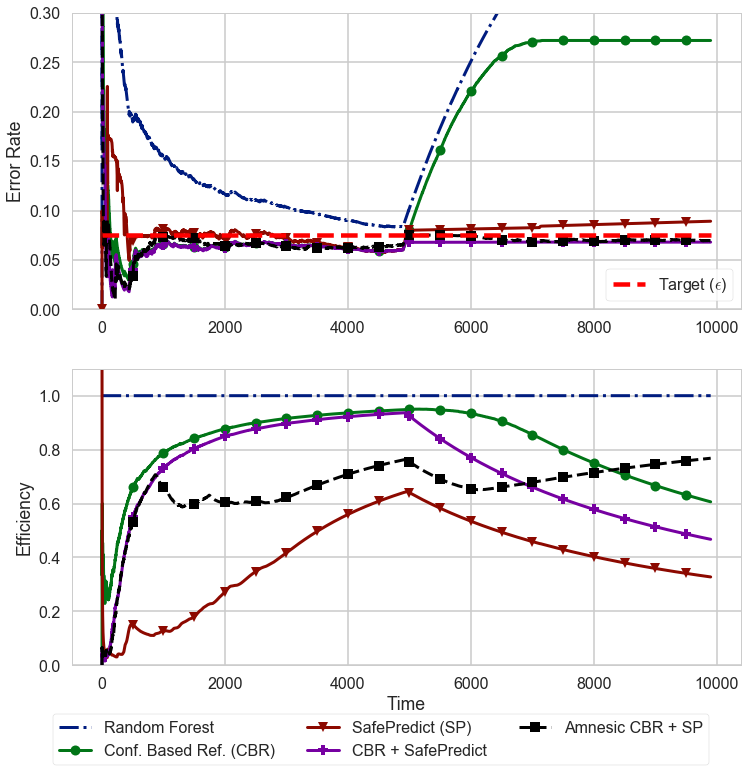

In [8]:
WW  = 15; HH = 18; 
WW  = 12; HH = 12; 
ll = 3; me = 500; ms = 10

plt.figure(figsize=(WW,HH))


# ERROR PLOT 
ax = plt.subplot(2,1,1)
plt.plot(np.cumsum(Lp1)/np.arange(T-tl),  linestyle='-.', linewidth=ll)
plt.plot(np.cumsum([i*j for i,j in zip(Wp_cb1,Lp1)])/np.cumsum(Wp_cb1), linestyle='-', linewidth=ll, marker = 'o', markevery=me, markersize = ms)
plt.plot(np.cumsum([i*j for i,j in zip(Wp_sp1,Lp1)])/np.cumsum(Wp_sp1), linestyle='-', linewidth=ll, marker = 'v', markevery=me, markersize = ms)
plt.plot(np.cumsum([i*j for i,j in zip(Wp_cbsp1,Lp1)])/np.cumsum(Wp_cbsp1), linestyle='-', linewidth=ll, marker = 'P', markevery=me, markersize = ms)
plt.plot(np.cumsum([i*j for i,j in zip(Wp_cbsp2,Lp2)])/np.cumsum(Wp_cbsp2),'k', linestyle='--', linewidth=ll, marker = 's', markevery=me, markersize = ms)
plt.plot([0, T-tl],[epsilon, epsilon], label = r'Target ($\epsilon$)', linestyle = '--', color = 'red', linewidth = ll*1.5)
lg = ax.legend(loc='best')
lg.draw_frame(True)
plt.ylim([0, 0.3]) #4*epsilon])
#plt.legend(loc =0)
plt.ylabel("Error Rate")
# EFFICIENCY PLOT
ax = plt.subplot(2,1,2)
plt.plot( np.ones(T-tl), label = 'Random Forest', linestyle='-.', linewidth=ll)
plt.plot( np.cumsum(Wp_cb1)/np.arange(T-tl), label = 'Conf. Based Ref. (CBR)', linestyle='-', linewidth=ll, marker = 'o', markevery=me, markersize = ms)
plt.plot( np.cumsum(Wp_sp1)/np.arange(T-tl), label = 'SafePredict (SP)', linestyle='-', linewidth=ll, marker = 'v', markevery=me, markersize =ms)
plt.plot( np.cumsum(Wp_cbsp1)/np.arange(T-tl), label = 'CBR + SafePredict', linestyle='-', linewidth=ll, marker = 'P', markevery=me, markersize = ms)
plt.plot( np.cumsum(Wp_cbsp2)/np.arange(T-tl),'k', label = 'Amnesic CBR + SP', linestyle='--', linewidth=ll, marker = 's', markevery=me, markersize =ms)
lg = ax.legend(loc='center left', bbox_to_anchor=(-0.04, -0.25), ncol = 3)
lg.draw_frame(True)
plt.ylim([0, 1.1])
plt.ylabel("Efficiency")
plt.xlabel("Time")